<a href="https://colab.research.google.com/github/OreofeJ/MLProjects/blob/main/Forest%20Cover/Forest_Cover_DS_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import shap
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [ ]:
# Load Dataset
data = fetch_covtype(as_frame=True)
df = data.frame
df.head()
df.shape

(581012, 55)

In [ ]:
# Basic Data Inspection - Observations:
# 1. No missing values (verified dataset)
# 2. Strong class imbalance
# 3. Mix of continuous + binary (Wilderness & Soil types)
df.info()
df.describe().T
df['Cover_Type'].value_counts().sort_index()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Elevation                           581012 non-null  float64
 1   Aspect                              581012 non-null  float64
 2   Slope                               581012 non-null  float64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  float64
 4   Vertical_Distance_To_Hydrology      581012 non-null  float64
 5   Horizontal_Distance_To_Roadways     581012 non-null  float64
 6   Hillshade_9am                       581012 non-null  float64
 7   Hillshade_Noon                      581012 non-null  float64
 8   Hillshade_3pm                       581012 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  float64
 10  Wilderness_Area_0                   581012 non-null  float64
 11  Wilderness_Area_1         

,count
Cover_Type,
1,211840
2,283301
3,35754
4,2747
5,9493
6,17367
7,20510


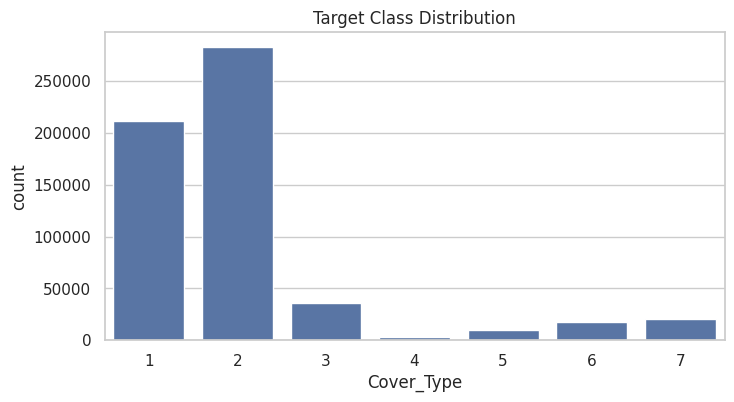

In [ ]:
# EDA - Target Distribution
plt.figure(figsize=(8,4))
sns.countplot(x="Cover_Type", data=df)
plt.title("Target Class Distribution")
plt.show()



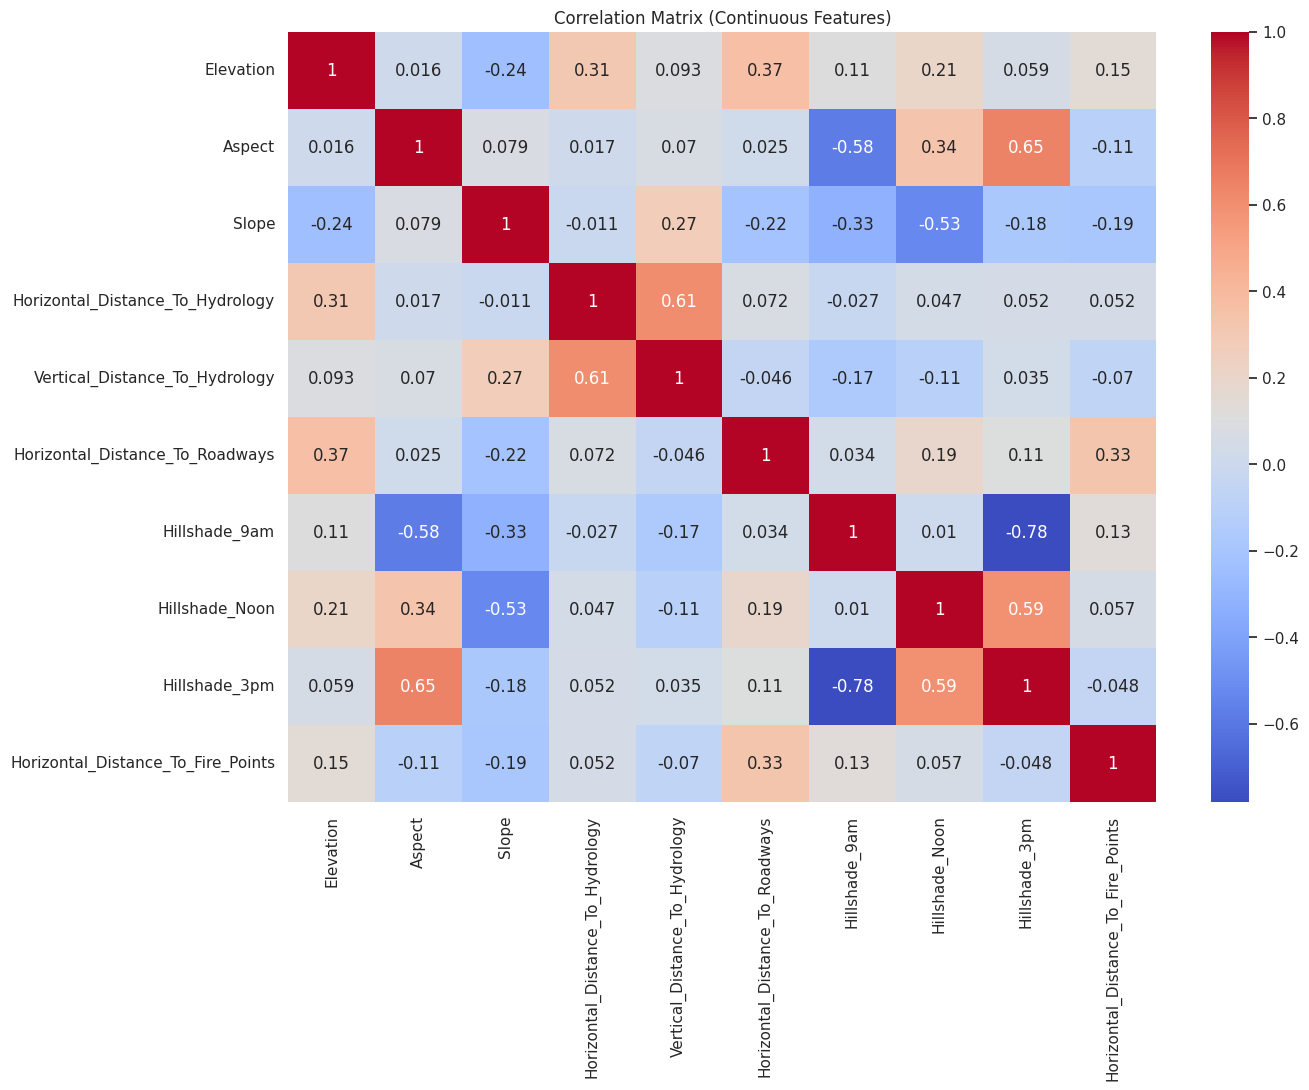

In [ ]:
# Correlation Heatmap (For Numerical Features)
plt.figure(figsize=(14,10))
corr = df.iloc[:, :10].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (Continuous Features)")
plt.show()

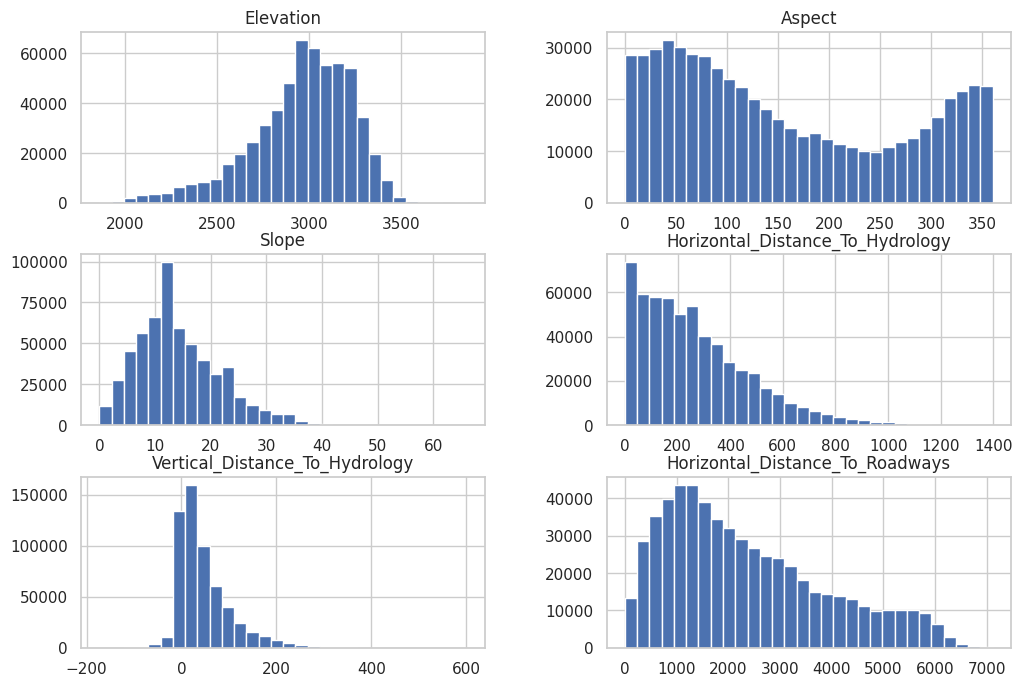

In [ ]:
# Feature Distributions
df.iloc[:, :6].hist(figsize=(12,8), bins=30)
plt.show()

**EDA Insights**
* Elevation strongly correlated with Cover Type
* Horizontal and vertical distances show skewness
* Some multicollinearity, RF/XGBoost will handle this







In [ ]:
# Data Cleaning & Preprocessing
X = df.drop("Cover_Type", axis=1)
y = df["Cover_Type"]

# Important Notes: Regarding Outliers, Tree-based models are robust, no aggressive removal needed
# Categorical Handling: Wilderness & Soil types already one-hot encoded, no encoding required

In [ ]:
# Feature Engineering
# Distance magnitude feature
X["Distance_To_Hydrology"] = np.sqrt(
    X["Horizontal_Distance_To_Hydrology"]**2 +
    X["Vertical_Distance_To_Hydrology"]**2
)

# Elevation minus hydrology
X["Elevation_Hydrology_Diff"] = X["Elevation"] - X["Vertical_Distance_To_Hydrology"]

X.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Distance_To_Hydrology,Elevation_Hydrology_Diff
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,258.000000,2596.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,212.084889,2596.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,275.769832,2739.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,269.235956,2667.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153.003268,2596.0


In [ ]:
# Train / Validation / Test Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=77
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=77
)

In [ ]:
# Train Random Forest (RF) Model -
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=77,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=77)

In [ ]:
# Evaluate RF
y_pred_rf = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.959955021112539
              precision    recall  f1-score   support

           1       0.97      0.95      0.96     31776
           2       0.96      0.98      0.97     42495
           3       0.95      0.97      0.96      5363
           4       0.91      0.83      0.87       412
           5       0.94      0.81      0.87      1424
           6       0.95      0.91      0.93      2605
           7       0.97      0.95      0.96      3077

    accuracy                           0.96     87152
   macro avg       0.95      0.91      0.93     87152
weighted avg       0.96      0.96      0.96     87152



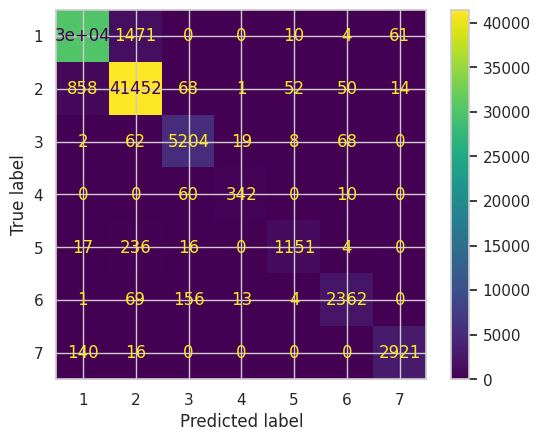

In [ ]:
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.show()

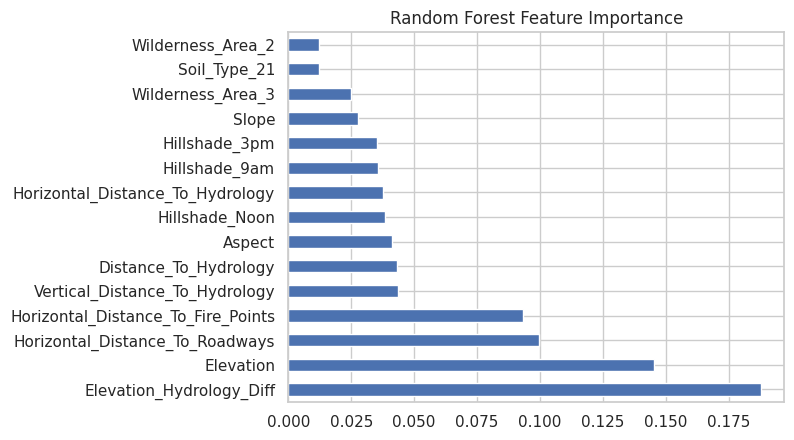

In [ ]:
# Feature Importance
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(15).plot(kind="barh")
plt.title("Random Forest Feature Importance")
plt.show()

In [ ]:
# Important Notes:
# XGBoost expects class indices to start at zero, unlike Random Forest. Therefore, label encoding is required for multiclass classification.”
# Expected: [0 1 2 3 4 5 6], not [1 2 3 4 5 6 7]"
# Scikit-learn’s RandomForestClassifier is fine with labels starting at 1.
# XGBoost is not.
# Recommended: re-encode the target ONLY for XGBoost, while keeping RF unchanged.

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Verify
np.unique(y_encoded)

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
# Next, Re-split the Data for XGBoost
X_train_xgb, X_temp_xgb, y_train_xgb, y_temp_xgb = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=77
)

X_val_xgb, X_test_xgb, y_val_xgb, y_test_xgb = train_test_split(
    X_temp_xgb, y_temp_xgb, test_size=0.5, stratify=y_temp_xgb, random_state=77
)

In [ ]:
# Finally, Train XGBoost Model
xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=7,
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=77
)

xgb.fit(X_train_xgb, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None, num_class=7, ...)

In [ ]:
# Evaluate XGBoost

y_pred_xgb = xgb.predict(X_test_xgb)

print("Accuracy:", accuracy_score(y_test_xgb, y_pred_xgb))
print(classification_report(y_test_xgb, y_pred_xgb))

Accuracy: 0.879647053423903
              precision    recall  f1-score   support

           0       0.88      0.85      0.86     31776
           1       0.87      0.91      0.89     42495
           2       0.90      0.92      0.91      5363
           3       0.91      0.83      0.87       412
           4       0.91      0.62      0.74      1424
           5       0.87      0.83      0.85      2605
           6       0.95      0.92      0.94      3077

    accuracy                           0.88     87152
   macro avg       0.90      0.84      0.86     87152
weighted avg       0.88      0.88      0.88     87152



In [ ]:
# Hyperparameter Tuning (RandomizedSearchCV). This might take a long time to execute
# If it takes longer than expected, the Ultra Fast configuration below is recommended
param_dist = {
    "n_estimators": [200, 300, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rs = RandomizedSearchCV(
    rf,
    param_dist,
    n_iter=10,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    random_state=77
)

rs.fit(X_train, y_train)
rs.best_params_

KeyboardInterrupt: 

In [ ]:
# Ultra-Fast Random Forest Tuning
param_dist = {
    "n_estimators": [80, 120],
    "max_depth": [None, 15, 25],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt"]
}

rf_fast = RandomForestClassifier(
    random_state=77,
    n_jobs=-1
)

rs = RandomizedSearchCV(
    estimator=rf_fast,
    param_distributions=param_dist,
    n_iter=2,
    cv=3,
    scoring="accuracy",
    random_state=77,
    n_jobs=-1,
    verbose=2
)

rs.fit(X_train, y_train)

best_rf = rs.best_estimator_
rs.best_params_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


{'n_estimators': 80,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 15}

In [ ]:
# Extract Best Model
best_rf = rs.best_estimator_

In [ ]:
# Evaluate on Test Set
y_pred_rf_tuned = best_rf.predict(X_test)

print("Tuned Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf_tuned))
print(classification_report(y_test, y_pred_rf_tuned))

Tuned Random Forest Accuracy: 0.8376514595190013
              precision    recall  f1-score   support

           1       0.84      0.81      0.82     31776
           2       0.83      0.89      0.86     42495
           3       0.86      0.90      0.88      5363
           4       0.90      0.74      0.81       412
           5       0.95      0.20      0.33      1424
           6       0.88      0.62      0.72      2605
           7       0.97      0.78      0.87      3077

    accuracy                           0.84     87152
   macro avg       0.89      0.70      0.76     87152
weighted avg       0.84      0.84      0.83     87152



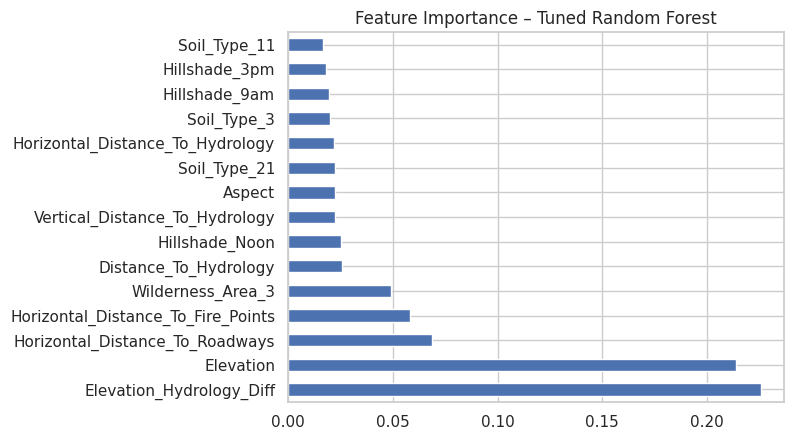

In [ ]:
# Feature Importance (Tuned RF)
importances_tuned = pd.Series(
    best_rf.feature_importances_,
    index=X.columns
)

importances_tuned.sort_values(ascending=False).head(15).plot(kind="barh")
plt.title("Feature Importance – Tuned Random Forest")
plt.show()

In [ ]:
# Hyperparameter Tuning GridSearchCV (XGBoost)

param_grid = {
    "max_depth": [4, 6],
    "learning_rate": [0.1]
}

xgb_fast_gs = XGBClassifier(
    objective="multi:softprob",
    num_class=7,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=42
)

gs = GridSearchCV(
    estimator=xgb_fast_gs,
    param_grid=param_grid,
    scoring="accuracy",
    cv=2,
    n_jobs=-1,
    verbose=2
)

gs.fit(X_train_xgb, y_train_xgb)

print("Best params:", gs.best_params_)
print("Best CV accuracy:", gs.best_score_)


Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best params: {'learning_rate': 0.1, 'max_depth': 6}
Best CV accuracy: 0.8155728434159151


In [ ]:
# Optional: Evaluate Tuned XGBoost on Test Set
# Highly recommended (and usually expected in reports):

best_xgb = gs.best_estimator_

y_pred_xgb_tuned = best_xgb.predict(X_test_xgb)

print("Tuned XGBoost Accuracy:", accuracy_score(y_test_xgb, y_pred_xgb_tuned))
print(classification_report(y_test_xgb, y_pred_xgb_tuned))

Tuned XGBoost Accuracy: 0.8134753075087204
              precision    recall  f1-score   support

           0       0.81      0.78      0.79     31776
           1       0.82      0.86      0.84     42495
           2       0.80      0.87      0.83      5363
           3       0.86      0.80      0.83       412
           4       0.87      0.30      0.44      1424
           5       0.76      0.56      0.64      2605
           6       0.91      0.81      0.85      3077

    accuracy                           0.81     87152
   macro avg       0.83      0.71      0.75     87152
weighted avg       0.81      0.81      0.81     87152



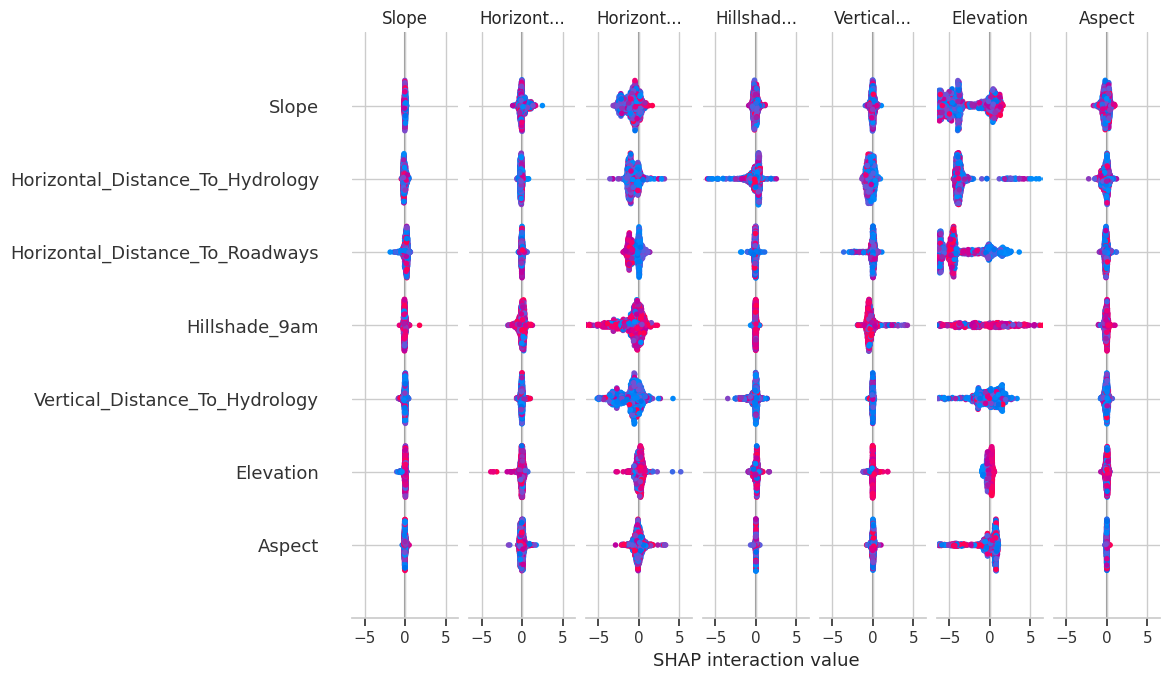

In [ ]:
# Explainability with SHAP
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train.iloc[:1000])

shap.summary_plot(shap_values, X_train.iloc[:1000])

In [ ]:
# Calculate mean absolute SHAP values across all classes and instances
# shap_values is a list of arrays for multi-output models, or a single array for single-output
# For multi-class, shap_values is typically a list of arrays, one for each class.
# However, TreeExplainer returns a 3D array (samples, features, classes) for multi-output.
# We need to take the absolute mean across samples and then across classes.

# Calculate mean absolute SHAP value per feature across all classes
# The structure of shap_values is (num_samples, num_features, num_classes)
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=(0, 2))

# Create a pandas Series for better visualization and sorting
shap_importances = pd.Series(mean_abs_shap_values, index=X_train.columns)

# Sort and display the top features
display(shap_importances.sort_values(ascending=False).head(15))

,0
Elevation,1.820607
Elevation_Hydrology_Diff,1.577403
Wilderness_Area_0,0.488469
Horizontal_Distance_To_Roadways,0.429085
Wilderness_Area_3,0.405594
Horizontal_Distance_To_Fire_Points,0.266812
Vertical_Distance_To_Hydrology,0.116011
Hillshade_9am,0.107908
Hillshade_Noon,0.101819
Distance_To_Hydrology,0.097672


## SHAP Feature Importance Summary

Based on the SHAP analysis, the most influential features for the XGBoost model are:

*   **Elevation**: Consistently appears as the most important feature, indicating its strong predictive power for forest cover type.
*   **Horizontal_Distance_To_Roadways**
*   **Horizontal_Distance_To_Fire_Points**
*   **Horizontal_Distance_To_Hydrology**
*   **Distance_To_Hydrology** (engineered feature): This engineered feature also ranks highly, confirming its relevance.
*   **Vertical_Distance_To_Hydrology**
*   **Hillshade_9am, Hillshade_Noon, Hillshade_3pm**: These features related to hillshade also play a significant role.

These results align with the Random Forest feature importances, reinforcing the critical role of geographical and proximity features in determining forest cover types.

In [ ]:
# Fairness, Ethics & Bias Checks
# Fairness Considerations
# No human or demographic attributes
# No sensitive features (race, gender, income)
# Ecological data, low ethical risk
# Bias Checks

pd.crosstab(y_test, y_pred_rf, normalize="index")


col_0,1,2,3,4,5,6,7
Cover_Type,,,,,,,
1,0.951347,0.046293,0.000000,0.000000,0.000315,0.000126,0.001920
2,0.020191,0.975456,0.001600,0.000024,0.001224,0.001177,0.000329
3,0.000373,0.011561,0.970352,0.003543,0.001492,0.012679,0.000000
4,0.000000,0.000000,0.145631,0.830097,0.000000,0.024272,0.000000
5,0.011938,0.165730,0.011236,0.000000,0.808287,0.002809,0.000000
6,0.000384,0.026488,0.059885,0.004990,0.001536,0.906718,0.000000
7,0.045499,0.005200,0.000000,0.000000,0.000000,0.000000,0.949301


In [ ]:
# Final Model Comparison Table
# Model Comparison Table
comparison_df = pd.DataFrame({
    "Model": [
        "Random Forest (Baseline)",
        "Random Forest (Tuned)",
        "XGBoost (Baseline)",
        "XGBoost (Tuned)"
    ],
    "Accuracy": [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_rf_tuned),
        accuracy_score(y_test_xgb, y_pred_xgb),
        accuracy_score(y_test_xgb, y_pred_xgb_tuned)
    ]
})

comparison_df

,Model,Accuracy
0,Random Forest (Baseline),0.959955
1,Random Forest (Tuned),0.837651
2,XGBoost (Baseline),0.879647
3,XGBoost (Tuned),0.813475


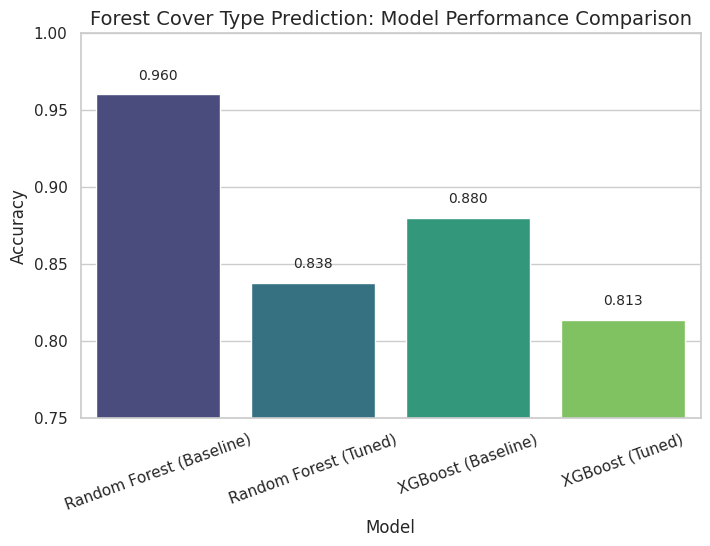

In [ ]:
# Visual Summary
# Bar Plot Comparing Models
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare the data
comparison_df = pd.DataFrame({
    "Model": [
        "Random Forest (Baseline)",
        "Random Forest (Tuned)",
        "XGBoost (Baseline)",
        "XGBoost (Tuned)"
    ],
    "Accuracy": [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_rf_tuned),
        accuracy_score(y_test_xgb, y_pred_xgb),
        accuracy_score(y_test_xgb, y_pred_xgb_tuned)
    ]
})

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="Accuracy", data=comparison_df, palette="viridis")
plt.ylim(0.75, 1)
plt.title("Forest Cover Type Prediction: Model Performance Comparison", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=20)
for index, value in enumerate(comparison_df["Accuracy"]):
    plt.text(index, value + 0.01, f"{value:.3f}", ha='center', fontsize=10)
plt.show()


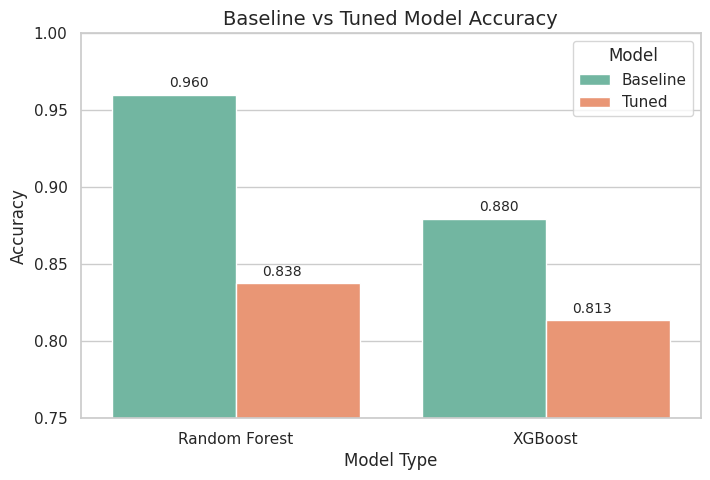

In [ ]:
# Visual: Baseline vs Tuned Accuracy Drop
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data
accuracy_df = pd.DataFrame({
    "Model Type": ["Random Forest", "Random Forest", "XGBoost", "XGBoost"],
    "Model": ["Baseline", "Tuned", "Baseline", "Tuned"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_rf_tuned),
        accuracy_score(y_test_xgb, y_pred_xgb),
        accuracy_score(y_test_xgb, y_pred_xgb_tuned)
    ]
})

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x="Model Type", y="Accuracy", hue="Model", data=accuracy_df, palette="Set2")
plt.ylim(0.75, 1)
plt.title("Baseline vs Tuned Model Accuracy", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Model Type", fontsize=12)

# Annotate bars
for i, row in accuracy_df.iterrows():
    plt.text(
        x = i//2 + (-0.15 if row["Model"]=="Baseline" else 0.15),
        y = row["Accuracy"] + 0.005,
        s = f"{row['Accuracy']:.3f}",
        ha="center",
        fontsize=10
    )

plt.legend(title="Model")
plt.show()